###  Load the master_df from s3

In [4]:
import os
import json
from pprint import pprint
import pandas as pd
from pandas.io.json import json_normalize
import re
import string
import glob
import matplotlib.pyplot as plt
import ast
from IPython.display import display, HTML
import numpy as np
pd.set_option('max_colwidth', 8000)
pd.options.display.max_columns = None
import s3_stuff as s3
import pandas as pd

In [6]:
#If not already exported, use this to set keys. Don't add this to github
%env AWS_SECRET_ACCESS_KEY=<>
%env AWS_ACCESS_KEY_ID=<>

env: AWS_SECRET_ACCESS_KEY=<>
env: AWS_ACCESS_KEY_ID=<>


In [5]:
#Create client to connect to s3. This client is an input param in subsequent functions
rcv_client = s3.open_s3_connections()
master_df  =s3.download_csv_from_s3_and_load_as_df(s3_connection=rcv_client,file_name='final_master.csv')
master_df

,round1winnervotes,round2winnervotes,round3winnervotes,round4winnervotes,round5winnervotes,round6winnervotes,round7winnervotes,total_votes_allrounds,num_candidates,noise,spoiled
0,11346,13632,0,0,0,0.0,0.0,24978,3.0,0.020000,1
1,11220,0,0,0,0,0.0,0.0,11220,3.0,0.030000,1
2,6243,10050,0,0,0,0.0,0.0,16293,3.0,0.046667,0
3,5246,5974,6964,8368,10437,13888.0,20829.0,71706,8.0,0.005000,1
4,17535,24995,0,0,0,0.0,0.0,42530,3.0,0.033333,1
...,...,...,...,...,...,...,...,...,...,...,...
26709,8603,12067,0,0,0,0.0,NaN,20670,3.0,0.016667,1
26710,2962,3429,4105,5114,6856,10260.0,NaN,32726,7.0,0.008571,1
26711,18078,26186,0,0,0,0.0,NaN,44264,3.0,0.043333,1
26712,2776,3592,4688,6703,0,0.0,NaN,17759,5.0,0.016000,0


In [3]:
master_df.spoiled.value_counts()


1    22999
0     3715
Name: spoiled, dtype: int64

In [4]:
master_df.describe()

,round1winnervotes,round2winnervotes,round3winnervotes,round4winnervotes,round5winnervotes,round6winnervotes,round7winnervotes,total_votes_allrounds,num_candidates,noise,spoiled
count,26714.000000,26714.000000,26714.000000,26714.000000,26714.000000,26525.000000,22434.000000,26714.000000,26714.000000,26714.000000,26714.000000
mean,9347.004604,10037.461893,4691.524182,1747.060680,558.821816,247.869105,84.530222,26698.975780,3.646440,0.020336,0.860934
std,6233.952966,8014.918694,7319.740469,4919.850218,2816.056116,1954.215131,1213.745309,16732.337769,0.957285,0.013379,0.346022
min,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,264.000000,3.000000,0.000000,0.000000
25%,4263.500000,3057.250000,0.000000,0.000000,0.000000,0.000000,0.000000,12784.250000,3.000000,0.010000,1.000000
50%,8469.000000,8845.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24847.500000,3.000000,0.020000,1.000000
75%,13473.000000,15756.000000,8068.750000,0.000000,0.000000,0.000000,0.000000,39150.000000,4.000000,0.030000,1.000000
max,38544.000000,34612.000000,31515.000000,26954.000000,25528.000000,25140.000000,24040.000000,82573.000000,8.000000,0.046667,1.000000


In [56]:
master_df.fillna(0, inplace=True)
X = master_df.iloc[:,:-1]
y = master_df.iloc[:,-1]

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17898, 10) (8816, 10) (17898,) (8816,)


In [18]:
X.columns

Index(['round1winnervotes', 'round2winnervotes', 'round3winnervotes',
       'round4winnervotes', 'round5winnervotes', 'round6winnervotes',
       'round7winnervotes', 'total_votes_allrounds', 'num_candidates',
       'noise'],
      dtype='object')

col:  round1winnervotes


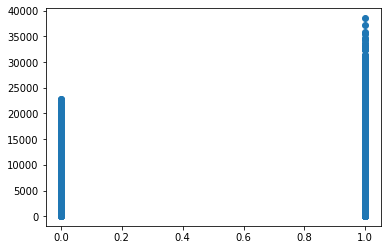

col:  round2winnervotes


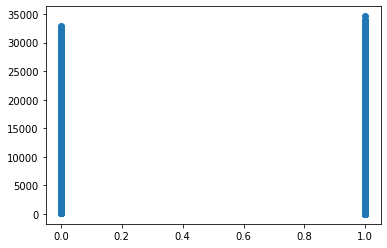

col:  round3winnervotes


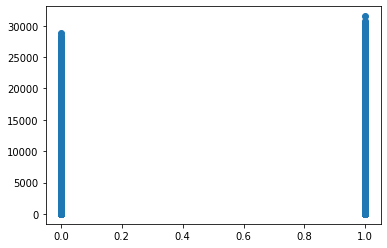

col:  round4winnervotes


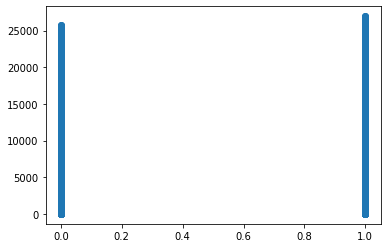

col:  round5winnervotes


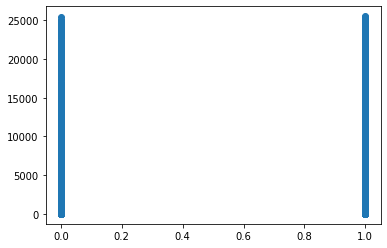

col:  round6winnervotes


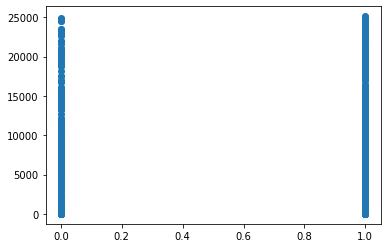

col:  round7winnervotes


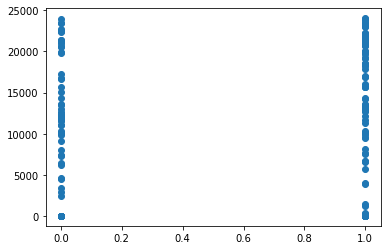

col:  total_votes_allrounds


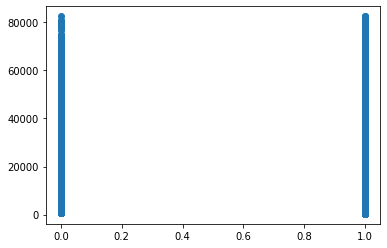

col:  num_candidates


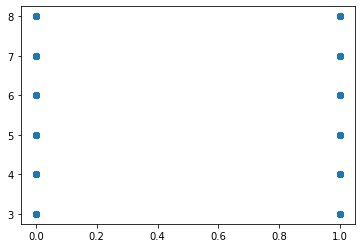

col:  noise


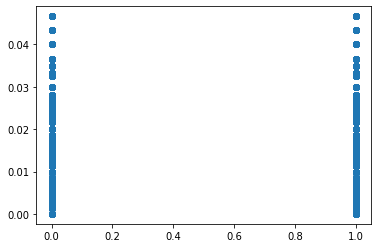

In [20]:
for col in X:
    print('col: ', col)
    plt.scatter(master_df['spoiled'],master_df[col])
    plt.show()

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [54]:
df= master_df.copy()

In [55]:
df[df.isin([np.nan, np.inf, -np.inf]).any(1)]

,round1winnervotes,round2winnervotes,round3winnervotes,round4winnervotes,round5winnervotes,round6winnervotes,round7winnervotes,total_votes_allrounds,num_candidates,noise,spoiled
7398,4843,5772,7406,9746,14340,0.0,NaN,42107,6.0,0.021667,1
7399,5805,6292,0,0,0,0.0,NaN,12097,3.0,0.036667,1
7400,6686,10493,0,0,0,0.0,NaN,17179,3.0,0.000000,1
7401,8063,11588,15108,0,0,0.0,NaN,34759,4.0,0.020000,1
7402,3168,3756,4592,6095,9285,0.0,NaN,26896,6.0,0.018333,1
...,...,...,...,...,...,...,...,...,...,...,...
26709,8603,12067,0,0,0,0.0,NaN,20670,3.0,0.016667,1
26710,2962,3429,4105,5114,6856,10260.0,NaN,32726,7.0,0.008571,1
26711,18078,26186,0,0,0,0.0,NaN,44264,3.0,0.043333,1
26712,2776,3592,4688,6703,0,0.0,NaN,17759,5.0,0.016000,0


In [31]:
df['round7winnervotes'] = df['round7winnervotes'].fillna(0)

df['round6winnervotes'] = df['round6winnervotes'].fillna(0)


In [39]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
calc_vif(X)

/Users/shvarugh/.pyenv/versions/jupyter3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,round1winnervotes,inf
1,round2winnervotes,inf
2,round3winnervotes,inf
3,round4winnervotes,inf
4,round5winnervotes,inf
5,round6winnervotes,inf
6,round7winnervotes,inf
7,total_votes_allrounds,inf
8,num_candidates,6.028770
9,noise,3.264022


In [41]:
calc_vif(df.iloc[:,[0,7,8,9]])

,variables,VIF
0,round1winnervotes,5.033652
1,total_votes_allrounds,7.343221
2,num_candidates,5.269752
3,noise,2.988050


In [42]:
calc_vif(df.iloc[:,[0,8,9]])

,variables,VIF
0,round1winnervotes,2.663514
1,num_candidates,2.995106
2,noise,2.799062


In [43]:
from sklearn.linear_model import LogisticRegression

In [59]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)


LogisticRegression()

In [63]:
predictions = logisticRegr.predict(X_test)
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print(score)

In [64]:
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print(score)

0.8608212341197822


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [66]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[   4 1222]
 [   5 7585]]


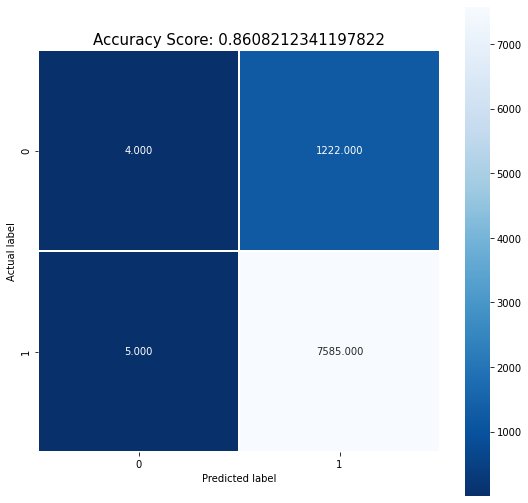

In [67]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [69]:
#SMOTE


In [71]:
!pip install imblearn

     |████████████████████████████████| 206 kB 1.6 MB/s eta 0:00:01
You should consider upgrading via the '/Users/shvarugh/.pyenv/versions/3.6.1/envs/jupyter3/bin/python3.6 -m pip install --upgrade pip' command.


In [72]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [76]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)



In [77]:
X_res.shape

(30818, 10)

In [78]:
y_res

0        1
1        1
2        1
3        1
4        1
        ..
30813    0
30814    0
30815    0
30816    0
30817    0
Name: spoiled, Length: 30818, dtype: int64

In [79]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_res, y_res)

LogisticRegression()

In [80]:
predictions = logisticRegr.predict(X_test)
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print(score)

0.584051724137931


In [82]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[ 948  278]
 [3389 4201]]


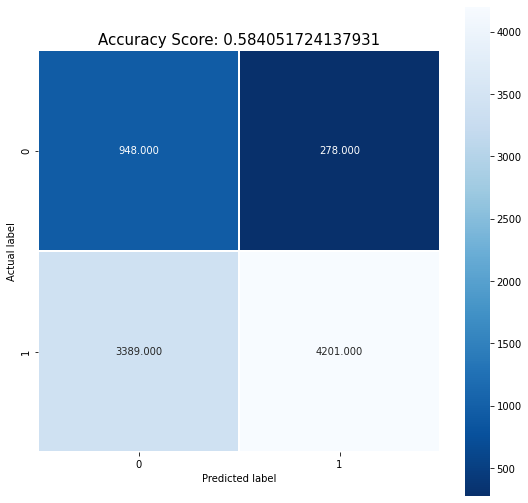

In [83]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);